In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
data_dir = '/Volumes/ATLAS/reanalysis/'
nc_file = 'NA_2m_temp_1900-2010.nc'
#months = pd.date_range('1900-01-01','2010-12-01',freq='MS')

In [3]:
#load nc file
nc_temp = xr.open_dataset(data_dir+nc_file)
#extract data from netcdf structure
t2m = nc_temp['t2m']

In [4]:
#label of time slice
t_season='AMJ'
#months to extract
t_months=[4,5,6]
#analysis time period
start_year = '1970-01-01'
end_year = '2010-12-01'
#spatial extent of the analysis
ext_e = -90
ext_w = -120
ext_n = 55
ext_s = 30

In [5]:
def extract_months(month):
    return (month >= 4) & (month <= 6)

In [6]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month']))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1981-01-01','2010-12-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month']))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [7]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [8]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
for i in np.arange(0,len(t2m['latitude'])):
    for j in np.arange(0,len(t2m['longitude'])):
        series = t2m_months_avg[:,i,j]
        anom = series-t2m_clim_months_avg[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope*10
        pvalues[i,j]=p_value
        #print(i)

In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'spatial_trends_temp_'+t_season+'_'+start_year+'mtwb'+'.nc')

/Users/gbromley/anaconda/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


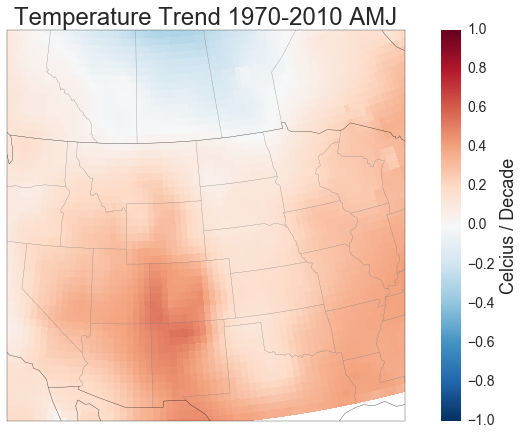

In [9]:
fig, ax = plt.subplots();
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax, transform=ccrs.PlateCarree(),vmin=-1, vmax=1, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.title('Temperature Trend 1970-2010 '+t_season,fontsize=24)
test.colorbar.set_label('Celcius / Decade',fontsize=18)
test.colorbar.ax.tick_params(labelsize=14)
fig.set_size_inches(13,7)
fig.set_dpi=1200.0
#plt.savefig('Temp_spatial_mtwb_'+t_season+'_1970.png')
plt.show()

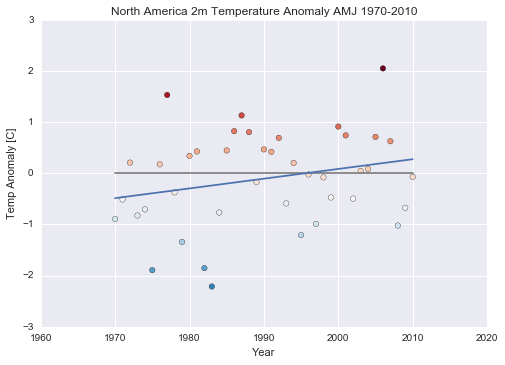

In [11]:
anom_series = t2m_months_avg-t2m_clim_months_avg
extent = anom_series.sel(latitude=np.arange(ext_s,ext_n,step=.5))
extent = extent.sel(longitude=np.arange(ext_w+360,ext_e+360,step=.5))
extent_series = extent.mean(dim=['latitude','longitude'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



fig, ax = plt.subplots();
plt.scatter(extent_series['year'],extent_series.values, c=extent_series.values,vmin=-3,vmax=2,cmap='RdBu_r',s=30);
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['year'],base,c='grey')
ax.set_title('North America 2m Temperature Anomaly '+t_season+' 1970-2010')
ax.set_xlabel('Year')
ax.set_ylabel('Temp Anomaly [C]')
trend = ax.plot(extent_series['year'],line)
#fig.savefig('2m_temp_anom_'+t_season+'_na_sp_1970.png')